# Iteratively running random forest on WA HUC units using subsets of training data and raster stacks from full WA state

In [73]:
library(terra)
library(tidyterra)
library(stringr)
library(dplyr)
library(randomForest)
library(caret)
library(ggplot2)
library(lme4)
set.seed(11)


Loading required package: Matrix



In [2]:
wa_shp <- vect("data/wa_shp_diss.gpkg")
wa_hucs <- vect("data/Hydrography/WA_HUC8.gpkg")
wa_hucs$name

[1] "Willapa Bay"                  "Lower Skagit"                
 [3] "Upper Skagit"                 "Skykomish"                   
 [5] "Snohomish"                    "Lake Washington"             
 [7] "Hangman"                      "Upper Crab"                  
 [9] "Palouse"                      "Rock"                        
[11] "Klickitat"                    "Nisqually"                   
[13] "Puget Sound"                  "Sumas River"                 
[15] "Lower Grande Ronde"           "Lower Snake-Asotin"          
[17] "Middle Columbia-Lake Wallula" "Walla Walla"                 
[19] "Little Spokane"               "Queets-Quinault"             
[21] "Hoh-Quillayute"               "Lower Chehalis"              
[23] "Grays Harbor"                 "Nooksack"                    
[25] "Sauk"                         "Stillaguamish"               
[27] "Duwamish"                     "Puyallup"                    
[29] "Colville"                     "Sanpoil"                     
[31] "Chief Joseph"                 "Methow"                      
[33] "Lake Chelan"                  "Upper Columbia-Entiat"       
[35] "Wenatchee"                    "Moses Coulee"                
[37] "Banks Lake"                   "Lower Crab"                  
[39] "Lower Snake"                  "Kettle"                      
[41] "Snoqualmie"                   "Okanogan"                    
[43] "Similkameen"                  "Upper Spokane"               
[45] "Lower Snake-Tucannon"         "Deschutes"                   
[47] "Skokomish"                    "Hood Canal"                  
[49] "Strait of Georgia"            "San Juan Islands"            
[51] "Dungeness-Elwha"              "Coeur d'Alene Lake"          
[53] "Clearwater"                   "Pend Oreille Lake"           
[55] "Priest"                       "Naches"                      
[57] "Upper Cowlitz"                "Lower Spokane"               
[59] "Lower Columbia-Clatskanie"    "Middle Columbia-Hood"        
[61] "Lower Columbia-Sandy"         "Pend Oreille"                
[63] "Upper Columbia-Priest Rapids" "Lower Yakima"                
[65] "Franklin D. Roosevelt Lake"   "Upper Chehalis"              
[67] "Lower Cowlitz"                "Lower Columbia"              
[69] "Upper Yakima"                 "Crescent-Hoko"               
[71] "Lewis"

In [3]:
datapath <- paste0(getwd(), "/data/huc_data")
datapath

[1] "/home/ajs0428/WIP Testing/data/huc_data"

In [4]:
str_replace_all(paste0(values(wa_hucs[52])), "[^[:alnum:]]", "")

[1] "CoeurdAleneLake"

In [6]:
str_replace_all(paste0(values(wa_hucs[52])), "[^[:alnum:]]", "")

[1] "CoeurdAleneLake"

In [7]:
list_rasts <- as.list(list.files(path = datapath, 
                                 full.names = TRUE, 
                                 pattern = "Skykomish",
                                 include.dirs = FALSE))
list_rasts

list_pts <- as.list(list.files(path = paste0(datapath, "/points"), 
                                 full.names = TRUE, 
                                 pattern = "Skykomish",
                                 include.dirs = FALSE))
list_pts

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/clim_stackSkykomish.tif"

[[2]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/terr_stackSkykomish.tif"

[[3]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/wa_specSkykomish.tif"

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/points/Skykomish_pts.gpkg"

In [8]:
terr_rast <- (list_rasts[grep('terr', (list_rasts))])[[1]]
(terr_rast)

deparse(substitute(terr_rast))

[1] "/home/ajs0428/WIP Testing/data/huc_data/terr_stackSkykomish.tif"

[1] "terr_rast"

In [9]:
wip_rf_func <- function(hucs, path) {
    for(i in 1:length(hucs)){
        nameClean <- str_replace_all(paste0(values(hucs[i])), "[^[:alnum:]]", "")
        rasts <- as.list(list.files(path = path, 
                                     full.names = TRUE, 
                                     pattern = nameClean,
                                     include.dirs = FALSE))
    
        pts <- as.list(list.files(path = paste0(path, "/points"), 
                                     full.names = TRUE, 
                                     pattern = nameClean,
                                     include.dirs = FALSE))
      
        training_pts <- vect(pts[[1]])
        terr_rast <- rast((rasts[grep('terr', (rasts))])[[1]])
        spec_rast <- rast((rasts[grep('spec', (rasts))])[[1]])
        clim_rast <- rast((rasts[grep('clim', (rasts))])[[1]])
        
        pts_ext <-  training_pts |>
                terra::extract(x = terr_rast, bind = T) |> 
                terra::extract(x = spec_rast, bind = T) |> 
                terra::extract(x = clim_rast, bind = T) |> 
                as.data.frame() |> 
                dplyr::mutate(class = as.factor(class)) |>
                na.exclude() |>
                write.csv(paste0(path, "/RF_Models/", 
                                 nameClean, "rf_df", ".csv"))
        
        pts_ext <- read.csv(paste0(path, "/RF_Models/", 
                                 nameClean, "rf_df", ".csv"),
                            stringsAsFactors = T) |>
                    select(-X)

        train.index <- as.vector(sample(c(1:nrow(pts_ext)), 0.7*nrow(pts_ext), replace=F))
        train <- pts_ext[train.index, ]
        test <- pts_ext[-train.index, ]

        rf_model <- randomForest(as.factor(class) ~ ., mtry = 10, 
                         sampsize = nrow(train[train$class == "WET",]),
                         replace = TRUE, #weights = wetwt, 
                         nodesize =1,
                         ntree = 1000, na.action = na.omit,
                         importance = TRUE, data = train)
        
        test_predict <- predict(rf_model, newdata = test, type = "response") 
        cm <- caret::confusionMatrix(test_predict, as.factor(test$class))
        
        cmtocsv <- data.frame(cbind(t(cm$overall),t(cm$byClass)))
        write.csv(cmtocsv,file=paste0(path, "/RF_Models/",
                                          nameClean, "rf_model_testCM", ".csv"))
        
        save(rf_model, file = paste0(path, "/RF_Models/",
                                          nameClean, "rf_model", ".RData"))
        
        
    }
}


In [10]:
(read.csv("data/huc_data/RF_Models/WillapaBayrf_df.csv")) |> select(-X)

class,NASADEM_HGT_n49w125,wa_dev27,wa_dev3,wa_dev81,wa_dinfsca,wa_planc,wa_profc,wa_rugged,wa_slope,wa_twi,tree_canopy_cover,NDVI_median,MNDWI_median,EVI_median,SAVI_median,NDYI_median,PRISM_ppt_30yr_normal_800mM4_annual_asc,PRISM_tmean_30yr_normal_800mM4_annual_asc,PRISM_vpdmax_30yr_normal_800mM5_annual_asc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UPL,252.37039,1.71229064,0.404718518,0.99732733,23.64304,-109.9653397,-16.78282356,3.1088521,7.831114,5.146937,48,0.8618424,-0.4731505,0.6096296,0.5642698,0.3925666,2111.389,9.942524,8.928565
UPL,95.20844,0.33688301,0.171113312,0.03325610,48.10867,-35.3265533,-15.35251808,5.8289304,15.577097,5.150815,71,0.8842267,-0.4287393,0.5104768,0.4955263,0.4536554,2220.057,10.114711,7.467491
UPL,18.99114,-0.37771761,-0.099987179,-0.06977453,198.03239,-5.6718602,11.75521564,3.0680344,8.445221,7.195778,69,0.8792042,-0.3555513,0.5337614,0.4986876,0.3504676,1981.025,10.340429,5.692378
UPL,267.15887,0.09637658,0.400524020,0.12759642,65.29999,-210.5907745,-0.28661224,2.6276484,6.330142,6.377816,69,0.8868247,-0.4869721,0.4912096,0.4802504,0.4006953,2239.556,10.150649,9.053707
UPL,260.97882,0.60984939,0.345292032,-0.41702569,34.64548,-152.5375214,-14.78480148,4.7672243,11.855162,5.106216,24,0.7964576,-0.5048729,0.5655997,0.5281631,0.3430617,3136.295,9.119939,6.982721
UPL,12.61012,0.38266692,0.855835795,0.94877410,202.89671,-454.0305176,-7.87652493,0.6842398,1.324764,9.079512,24,0.6361567,-0.5224981,0.3481876,0.3588439,0.2929648,1913.242,10.384675,5.581001
UPL,165.66519,0.70306218,0.350883394,0.09788849,23.64304,-52.2910919,-41.90360260,5.8647685,14.795408,4.494399,64,0.7046328,-0.5398110,0.3945974,0.3904073,0.2573591,2075.897,9.893797,8.273746
UPL,412.67575,-0.59741431,-0.334197879,-0.59184980,23.64304,266.7649536,-2.79217577,4.5353384,10.420210,4.856438,52,0.8808236,-0.4901453,0.6270771,0.5863945,0.4825270,3223.348,9.533335,8.151269
UPL,70.15858,-1.09573185,-0.356102347,-1.25628364,140.37744,88.1570129,12.74085045,1.7458470,4.467402,7.493725,57,0.9079086,-0.5272024,0.6210386,0.5759519,0.4042287,2011.150,10.285877,9.130339


In [26]:
wip_rf_func(wa_hucs, datapath)

In [27]:
test <- get(load("data/huc_data/RF_Models/WillapaBayrf_model.RData"))

In [28]:
test$importance

,UPL,WET,MeanDecreaseAccuracy,MeanDecreaseGini
NASADEM_HGT_n49w125,1.113097e-01,0.3312413481,0.1700647573,460.752385
wa_dev27,1.261361e-02,0.0143238826,0.0130692577,40.187424
wa_dev3,3.399413e-03,0.0021212702,0.0030572197,18.723780
wa_dev81,2.065065e-02,0.0619850982,0.0316921700,83.075704
wa_dinfsca,3.675786e-04,0.0006799878,0.0004506694,9.433999
wa_planc,2.193382e-03,0.0000540085,0.0016223656,19.152147
wa_profc,2.171285e-05,0.0084648952,0.0022775265,20.952229
wa_rugged,1.443087e-02,0.0246699651,0.0171663260,56.399527
wa_slope,9.462531e-03,0.0265555293,0.0140293232,51.457242
wa_twi_nozeroslp,1.959302e-03,0.0165772125,0.0058685025,17.681395


Combine all test confusion matrix dataframes and compare accuracies

In [29]:
read.csv("data/huc_data/RF_Models/WillapaBayrf_model_testCM.csv") 

X,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,Detection.Prevalence,Balanced.Accuracy
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9169788,0.7895877,0.9088183,0.9246284,0.7280483,2.936662e-238,0.48338,0.9451272,0.841622,0.9410928,0.8513932,0.9410928,0.9451272,0.9431057,0.7280483,0.6880982,0.7311694,0.8933746


## Visualize the accuracy results for each model

In [30]:
list_testacc <- as.list(list.files(path = paste0(datapath, "/RF_Models"), 
                                 full.names = TRUE, 
                                 pattern = "CM.csv",
                                 include.dirs = FALSE))

list_testacc

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/BanksLakerf_model_testCM.csv"

[[2]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/ChiefJosephrf_model_testCM.csv"

[[3]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Clearwaterrf_model_testCM.csv"

[[4]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/CoeurdAleneLakerf_model_testCM.csv"

[[5]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Colvillerf_model_testCM.csv"

[[6]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/CrescentHokorf_model_testCM.csv"

[[7]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Deschutesrf_model_testCM.csv"

[[8]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/DungenessElwharf_model_testCM.csv"

[[9]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Duwamishrf_model_testCM.csv"

[[10]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/FranklinDRooseveltLakerf_model_testCM.csv"

[[11]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/GraysHarborrf_model_testCM.csv"

[[12]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Hangmanrf_model_testCM.csv"

[[13]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/HohQuillayuterf_model_testCM.csv"

[[14]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/HoodCanalrf_model_testCM.csv"

[[15]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Kettlerf_model_testCM.csv"

[[16]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Klickitatrf_model_testCM.csv"

[[17]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LakeChelanrf_model_testCM.csv"

[[18]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LakeWashingtonrf_model_testCM.csv"

[[19]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Lewisrf_model_testCM.csv"

[[20]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LittleSpokanerf_model_testCM.csv"

[[21]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerChehalisrf_model_testCM.csv"

[[22]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerColumbiaClatskanierf_model_testCM.csv"

[[23]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerColumbiarf_model_testCM.csv"

[[24]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerColumbiaSandyrf_model_testCM.csv"

[[25]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerCowlitzrf_model_testCM.csv"

[[26]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerCrabrf_model_testCM.csv"

[[27]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerGrandeRonderf_model_testCM.csv"

[[28]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSkagitrf_model_testCM.csv"

[[29]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSnakeAsotinrf_model_testCM.csv"

[[30]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSnakerf_model_testCM.csv"

[[31]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSnakeTucannonrf_model_testCM.csv"

[[32]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSpokanerf_model_testCM.csv"

[[33]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerYakimarf_model_testCM.csv"

[[34]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Methowrf_model_testCM.csv"

[[35]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/MiddleColumbiaHoodrf_model_testCM.csv"

[[36]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/MiddleColumbiaLakeWallularf_model_testCM.csv"

[[37]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/MosesCouleerf_model_testCM.csv"

[[38]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Nachesrf_model_testCM.csv"

[[39]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Nisquallyrf_model_testCM.csv"

[[40]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Nooksackrf_model_testCM.csv"

[[41]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Okanoganrf_model_testCM.csv"

[[42]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Palouserf_model

In [31]:
empty <- list()
for(i in 1:length(list_testacc)){
    csv <- read.csv(list_testacc[[i]])
    csv$X <- substr(list_testacc[[i]], 51, 60)
    empty[[i]] <- csv
}

In [32]:
testacc <- bind_rows(empty)
testacc

X,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,Detection.Prevalence,Balanced.Accuracy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BanksLaker,0.9572864,0.6217000,0.9483873,0.9650404,0.9275544,1.110522e-09,5.161793e-09,0.9905192,0.5317919,0.9643956,0.8141593,0.9643956,0.9905192,0.9772829,0.9275544,0.9187605,0.9526801,0.7611555
ChiefJosep,0.9538589,0.8135281,0.9482546,0.9590183,0.8479668,6.104988e-152,9.404730e-08,0.9816011,0.7991266,0.9646086,0.8861985,0.9646086,0.9816011,0.9730307,0.8479668,0.8323651,0.8629046,0.8903639
Clearwater,1.0000000,1.0000000,0.8722971,1.0000000,0.8148148,3.968174e-03,NA,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.8148148,0.8148148,0.8148148,1.0000000
CoeurdAlen,0.9777778,0.9200710,0.8822957,0.9994375,0.8222222,1.603627e-03,1.000000e+00,1.0000000,0.8750000,0.9736842,1.0000000,0.9736842,1.0000000,0.9866667,0.8222222,0.8222222,0.8444444,0.9375000
Colvillerf,0.9336896,0.8178290,0.9264752,0.9403978,0.7575218,5.741100e-242,8.040400e-02,0.9605435,0.8497959,0.9523316,0.8733221,0.9523316,0.9605435,0.9564199,0.7575218,0.7276326,0.7640538,0.9051697
CrescentHo,0.9392835,0.3867795,0.9266425,0.9503289,0.9247116,1.221624e-02,1.360662e-14,0.9927774,0.2822581,0.9444097,0.7608696,0.9444097,0.9927774,0.9679898,0.9247116,0.9180328,0.9720704,0.6375177
Deschutesr,0.8829787,0.6744611,0.8593820,0.9038663,0.7529551,1.995807e-21,4.442318e-02,0.9387755,0.7129187,0.9088146,0.7925532,0.9088146,0.9387755,0.9235521,0.7529551,0.7068558,0.7777778,0.8258471
DungenessE,0.9194373,0.6455902,0.9104616,0.9277801,0.8575448,7.347407e-33,2.176285e-07,0.9668953,0.6337522,0.9408009,0.7607759,0.9408009,0.9668953,0.9536697,0.8575448,0.8291560,0.8813299,0.8003238
Duwamishrf,0.9108705,0.7332577,0.8987579,0.9219693,0.7838401,2.120503e-62,1.940080e-01,0.9484591,0.7745665,0.9384858,0.8056112,0.9384858,0.9484591,0.9434461,0.7838401,0.7434402,0.7921699,0.8615128


## Now we can try to generate a prediction in one of the watersheds

To do this we need a raster stack of the covariates in the same resolution and projection. Preferably in the resolution of the DEM used to make terrain metrics

In [33]:
wa_hucs$name

[1] "Willapa Bay"                  "Lower Skagit"                
 [3] "Upper Skagit"                 "Skykomish"                   
 [5] "Snohomish"                    "Lake Washington"             
 [7] "Hangman"                      "Upper Crab"                  
 [9] "Palouse"                      "Rock"                        
[11] "Klickitat"                    "Nisqually"                   
[13] "Puget Sound"                  "Sumas River"                 
[15] "Lower Grande Ronde"           "Lower Snake-Asotin"          
[17] "Middle Columbia-Lake Wallula" "Walla Walla"                 
[19] "Little Spokane"               "Queets-Quinault"             
[21] "Hoh-Quillayute"               "Lower Chehalis"              
[23] "Grays Harbor"                 "Nooksack"                    
[25] "Sauk"                         "Stillaguamish"               
[27] "Duwamish"                     "Puyallup"                    
[29] "Colville"                     "Sanpoil"                     
[31] "Chief Joseph"                 "Methow"                      
[33] "Lake Chelan"                  "Upper Columbia-Entiat"       
[35] "Wenatchee"                    "Moses Coulee"                
[37] "Banks Lake"                   "Lower Crab"                  
[39] "Lower Snake"                  "Kettle"                      
[41] "Snoqualmie"                   "Okanogan"                    
[43] "Similkameen"                  "Upper Spokane"               
[45] "Lower Snake-Tucannon"         "Deschutes"                   
[47] "Skokomish"                    "Hood Canal"                  
[49] "Strait of Georgia"            "San Juan Islands"            
[51] "Dungeness-Elwha"              "Coeur d'Alene Lake"          
[53] "Clearwater"                   "Pend Oreille Lake"           
[55] "Priest"                       "Naches"                      
[57] "Upper Cowlitz"                "Lower Spokane"               
[59] "Lower Columbia-Clatskanie"    "Middle Columbia-Hood"        
[61] "Lower Columbia-Sandy"         "Pend Oreille"                
[63] "Upper Columbia-Priest Rapids" "Lower Yakima"                
[65] "Franklin D. Roosevelt Lake"   "Upper Chehalis"              
[67] "Lower Cowlitz"                "Lower Columbia"              
[69] "Upper Yakima"                 "Crescent-Hoko"               
[71] "Lewis"

In [34]:
wa_hucs$name[wa_hucs$name == "Hoh-Quillayute"]

[1] "Hoh-Quillayute"

In [75]:
pred_rasts <- as.list(list.files(path = datapath, 
                                     full.names = TRUE, 
                                     #pattern = str_replace_all(paste0(values("Hoh")), "[^[:alnum:]]", ""),
                                     pattern = gsub(" ", "", paste0("Hoh")),
                                     include.dirs = FALSE))
pred_rasts

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/clim_stackHohQuillayute.tif"

[[2]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/terr_stackHohQuillayute.tif"

[[3]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/wa_specHohQuillayute.tif"

In [36]:
pred_terr <- rast((pred_rasts[grep('terr', (pred_rasts))])[[1]])
pred_spec <- rast((pred_rasts[grep('spec', (pred_rasts))])[[1]]) |> resample(pred_terr)
pred_clim <- rast((pred_rasts[grep('clim', (pred_rasts))])[[1]]) |> resample(pred_terr)


pred_terr
pred_spec

class       : SpatRaster 
dimensions  : 16959, 25378, 10  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 371131.6, 971144.8, 5043580, 5444542  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : terr_stackHohQuillayute.tif 
names       : NASAD~9w125,  wa_dev27,   wa_dev3,  wa_dev81, wa_dinfsca,  wa_planc, ... 
min values  :   -9.809053, -5.589353, -2.660863, -2.738247,   23.64304, -140051.4, ... 
max values  : 2375.422119,  6.429693,  2.652276, 10.030347, 6353.08691,  121935.2, ... 

class       : SpatRaster 
dimensions  : 16959, 25378, 6  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 371131.6, 971144.8, 5043580, 5444542  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : spat_77761b8d725_1911.tif 
names       : tree_~cover, NDVI_median, MNDWI_median, EVI_median, SAVI_median, NDYI_median 
min values  :     0.00000,  -0.6762745,   -0.6992204, -1.5645245,  -0.2205740,  -0.8907042 
max values  :    84.42554,   0.9634179,    0.9888086,  0.9329634,   0.7835603,   1.4909664 

In [37]:
pred_stack <- c(pred_terr, pred_spec, pred_clim)
names(pred_stack)

[1] "NASADEM_HGT_n49w125"                       
 [2] "wa_dev27"                                  
 [3] "wa_dev3"                                   
 [4] "wa_dev81"                                  
 [5] "wa_dinfsca"                                
 [6] "wa_planc"                                  
 [7] "wa_profc"                                  
 [8] "wa_rugged"                                 
 [9] "wa_slope"                                  
[10] "wa_twi_nozeroslp"                          
[11] "tree_canopy_cover"                         
[12] "NDVI_median"                               
[13] "MNDWI_median"                              
[14] "EVI_median"                                
[15] "SAVI_median"                               
[16] "NDYI_median"                               
[17] "PRISM_ppt_30yr_normal_800mM4_annual_asc"   
[18] "PRISM_tmean_30yr_normal_800mM4_annual_asc" 
[19] "PRISM_vpdmax_30yr_normal_800mM5_annual_asc"

X,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,Detection.Prevalence,Balanced.Accuracy
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8918449,0.6369622,0.8835314,0.8997584,0.7989915,1.098035e-79,3.839739e-19,0.9566921,0.634083,0.9122225,0.7864807,0.9122225,0.9566921,0.9339282,0.7989915,0.7643888,0.8379412,0.7953876


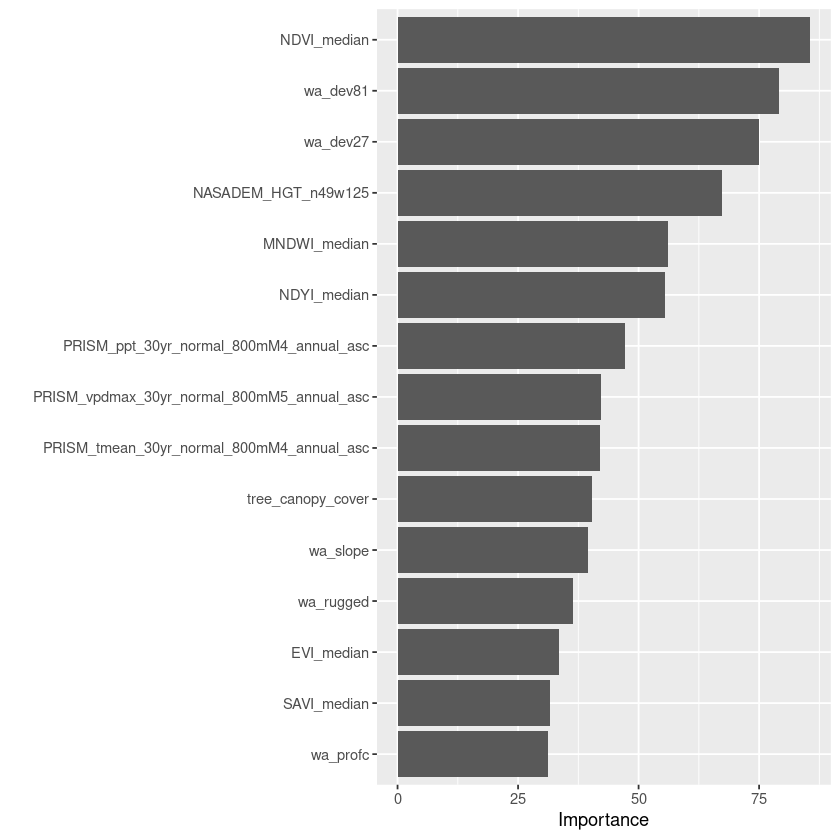

In [38]:
list_models <- as.list(list.files(path = paste0(datapath, "/RF_Models"), 
                                 full.names = TRUE, 
                                 pattern = "HohQuillayuterf_model",
                                 include.dirs = FALSE))
#list_models
read.csv(list_models[[1]])
pred_model <- get(load(list_models[[2]]))
vip::vip(pred_model, num_features = 15)

In [39]:
pred_wip <- predict(pred_stack, pred_model, type = "prob", 
                    filename = "data/huc_data/WIPs/HohQuillayute_WIP.tif", 
                    overwrite = TRUE)

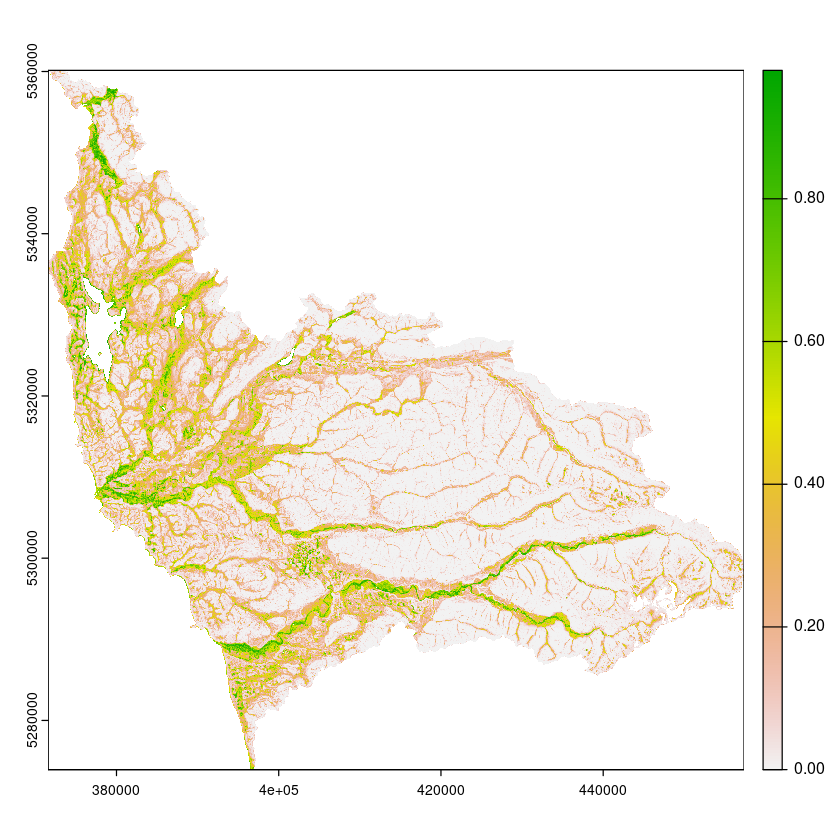

In [40]:
plot(pred_wip[[2]], ext = ext(vect("data/huc_data/points/HohQuillayute_pts.gpkg")))

In [44]:
hoh_cc <- vect("data/HOH_POLYGON_711.gpkg") |> terra::project("EPSG:3740")

hoh_30m <- crop(pred_wip, hoh_cc, mask = TRUE)
hoh_30m

class       : SpatRaster 
dimensions  : 1355, 2098, 2  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 386263.2, 435866.3, 5271711, 5303748  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source(s)   : memory
varname     : HohQuillayute_WIP 
names       :   UPL,   WET 
min values  : 0.035, 0.000 
max values  : 1.000, 0.965 

<SpatRaster> resampled to 500720 cells for plotting


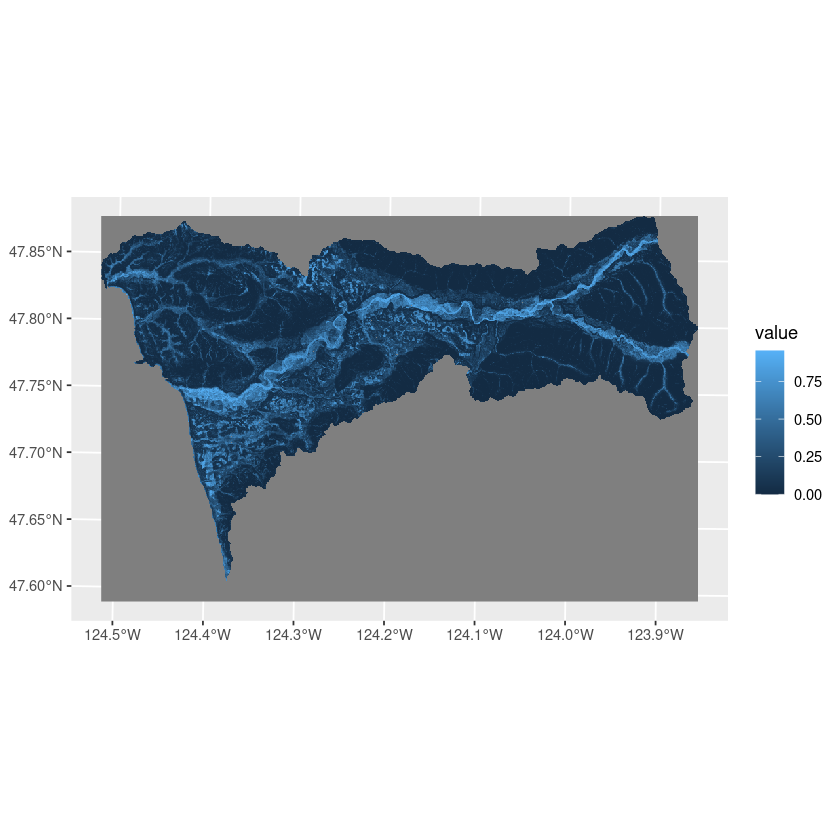

In [51]:
ggplot() + 
    geom_spatraster(data = hoh_30m[[2]])

## There can be issues with TWI 

Where:

$TWI = ln(\frac{As}{tan(Slope)})$, $As$ is the Specific Catchment Area

This may be a problem with:
1. the $tan(Slope)$ will be $0$ if $Slope = 0$
2. If $As = 0$ then the $ln(0)$ will be $-\infty$


## Putting together an iterative prediction mapping function

In [100]:
wip_map_func <- function(hucs, path) {
    for(i in 1:length(hucs)){
        nameClean <- str_replace_all(paste0(values(hucs[i])), "[^[:alnum:]]", "")
        rasts <- as.list(list.files(path = path, 
                                     full.names = TRUE, 
                                     pattern = nameClean,
                                     include.dirs = FALSE))
    
        pts <- as.list(list.files(path = paste0(path, "/points"), 
                                     full.names = TRUE, 
                                     pattern = nameClean,
                                     include.dirs = FALSE))
        
        mod <- get(load(as.list(list.files(path = paste0(path, "/RF_Models"), 
                                     full.names = TRUE, 
                                     pattern = paste0(nameClean, "rf_model.RData"),
                                     include.dirs = FALSE))[[1]]))
      
        training_pts <- vect(pts[[1]])
        terr_rast <- rast((rasts[grep('terr', (rasts))])[[1]])
        spec_rast <- rast((rasts[grep('spec', (rasts))])[[1]]) |> resample(terr_rast)
        clim_rast <- rast((rasts[grep('clim', (rasts))])[[1]]) |> resample(terr_rast)

        pred_stack <- c(terr_rast, spec_rast, clim_rast)

        pred_wip <- predict(pred_stack, mod, type = "prob", 
                    filename = paste0(path, "/WIPs/", nameClean, "_WIP.tif"), 
                    overwrite = TRUE)

        }
    }

In [101]:
testhucs <- wa_hucs[1:3]

In [102]:
wip_map_func(testhucs, datapath)

In [99]:
paste0(datapath, "/WIPs/", "RF", "_WIP.tif")

[1] "/home/ajs0428/WIP Testing/data/huc_data/WIPs/RF_WIP.tif"